Modified from:

[https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm](https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm).


GitHub: https://github.com/MYUSER/MYPROJECT/

Welcome to your assignment this week! 

To better understand adverse attacks againsts AI and how it is possible to fool an AI system, in this assignment, we will look at a Computer Vision use case. 




This assessment creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

# What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

# Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy find how each input pixel contributes to the loss, by using the chain rule, and finding the required gradients. Hence, the gradients are used with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.



# Part 1

So let's try and fool a pretrained model. In this first part, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).


Run the following cell to install all the packages you will need.

In [3]:
import sys
sys.executable 

'/Users/naimahassen/opt/anaconda3/bin/python'

In [4]:
! pip3 install cython
! pip3 install tensornets
! pip3 install numpy==1.16.1
! pip3 install tensorflow
! pip3 install matplotlib

Run the following cell to load the packages you will need.

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensornets as nets
import glob
import matplotlib.image as mpimg

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



Let's define the computation graph.

In [7]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image /  127.5
    image = image - 1.0
    image = image[None, ...]
    return image
def reverse_preprocess(image):
    image = image + 1.0
    image = image / 2.0
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=5)[0]


# Lets's import an image to process.
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_png(image_raw)
input_image = preprocess(image)
reversed_image = reverse_preprocess(input_image)

input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)

# node to load pretrained weights
pretrained_ops = pretrained_model.pretrained()

# decode predicted probabilities to ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions


Instructions for updating:
Please use `layer.__call__` method instead.


## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) -by Mirko       [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

sess.run(pretrained_ops)
preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



Let's have a look at the image.

['Labrador_retriever', 'Ibizan_hound', 'Saluki', 'Chesapeake_Bay_retriever', 'Weimaraner']


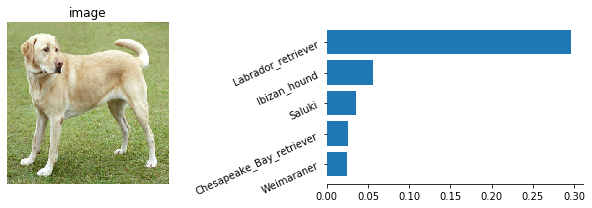

In [9]:
top5 = get_imagenet_label(image_probs[0])
tick_names = [x[1] for x in top5]
print(tick_names)
probs = [x[2] for x in top5]
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(reversed_img[0])
plt.title('image')
ax = plt.gca()
ax.axis('off')

plt.subplot(122)
tick_names = [x[1] for x in reversed(top5)]
probs = [x[2] for x in reversed(top5)]
plt.barh(tick_names, probs)
plt.yticks(rotation=25)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

# Create the adversarial image

## Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

**TASK 1:** Implement `create_adversarial_pattern()`. You will need to carry out 3 steps:

1. Create a loss object using `loss_object` using two arguments: `pretrained_model` and `input_label`.
2. Get the gradients using `tf.gradients` of the `loss`  w.r.t to the `input_image`.
3. Get the sign of the gradients to create the perturbation using `tf.sign`.


In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    ## START YOU CODE HERE (3 lines)
    loss = loss_object(input_label, pretrained_model) 
    gradient = tf.gradients(loss, input_image)
    signed_grad = tf.sign(gradient)[0]
    # END
    return signed_grad

The resulting perturbations can also be visualised.

(1, 224, 224, 3)


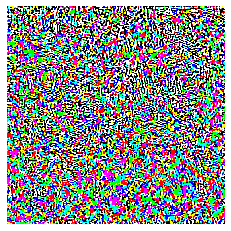

In [11]:
perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))
print(perturbations.shape)
p_cliped = tf.clip_by_value(perturbations, 0, 1)

p_cliped_val = sess.run(p_cliped, {input_image_placeholder: preprocessed_img})
plt.figure()
plt.imshow(p_cliped_val[0])
plt.gca().axis('off')
plt.show()

## Fool the AI system

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network, however, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [12]:
def display_images(image, description):
    rev_image = reverse_preprocess(image)
    adv_img, raw_adv_img = sess.run([image, rev_image], {input_image_placeholder: preprocessed_img})
    img_probs = sess.run(pretrained_model, {input_image_placeholder: adv_img})
    top5 = get_imagenet_label(img_probs)
    top5 = list(reversed(top5))
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(raw_adv_img[0])
    plt.title(description)
    plt.gca().axis('off')
    plt.subplot(122)
    tick_names = [x[1] for x in top5]
    probs = [x[2] for x in top5]
    plt.barh(tick_names, probs)
    plt.yticks(rotation=25)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    plt.show()

**TASK 2:** Generate adverse image using different values for $\epsilon$:

- adv_x = input_image + $\epsilon$ * perturbations


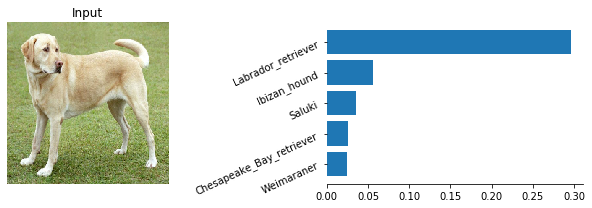

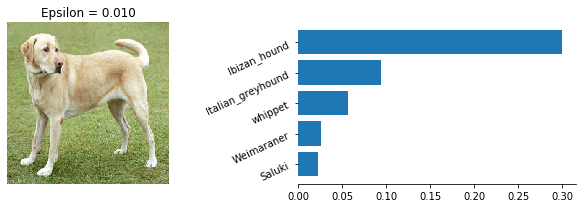

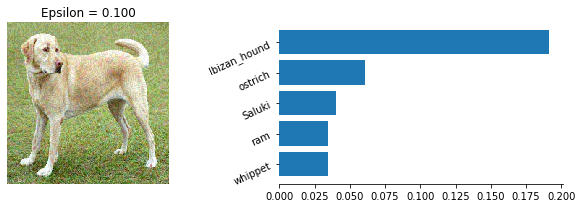

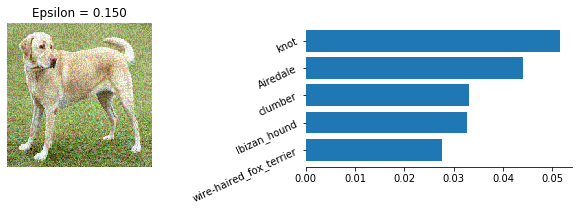

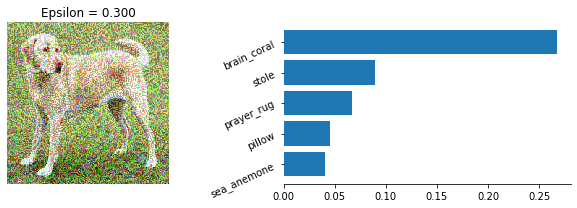

In [13]:
epsilons = [0, 0.01, 0.1, 0.15, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    ## START YOU CODE HERE
    adv_x = input_image + eps*perturbations
    ## End
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])



**TASK 3: What do you abserve?**

***

When there is an increase in epsilon value, there is also an increase as to how incorrectly the model will classify the image. And with the increase in epsilon value, there will also be more visible noise present in the adverse image. For example, an image with e= 0.01 will fool and misclassify and image but will still look like a labrador to the human eye. An emage with e=0.3 will have so much noise that the human can tell that the image is corrupt which will allow them to know that it will be misclassifed. 


***

#  Part 2

Here, you are required to process adversarial attacks using FGSM for a small subset of [ImageNet Dataset](http://www.image-net.org/). We prepared 100 images from different categories (in `./input_dir/`), and the labels are encoded in `./input_dir/clean_image.list`.

For evaluation, each adversarial image generated by the attack model will be fed to an evaluation model, and we will calculate the successful rate of adversarial attacks. **The adversarial images that can fool the evaluation model with $\epsilon$ = 0.01 will be considered as a success**.



**Task 4: Goal**

***

With the previous FGSM example, you are required to implement an FGSM attack against all examples and calculate the success rate. Also, display the original image with the attacked image as well as the predicted class for each image.


***

In [14]:
count = 0
list_of_files = sorted(glob.glob('./input_dir/*.JPEG'))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['goldfish', 'sea_slug', 'hummingbird', 'pot', 'flamingo']


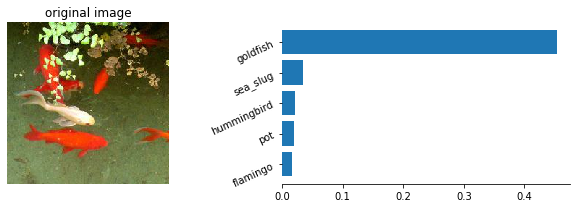

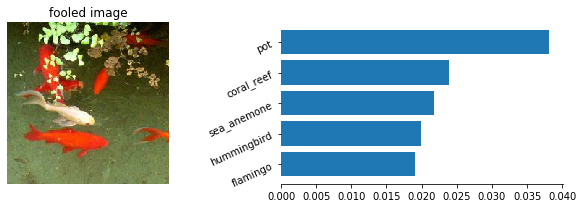

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['brambling', 'junco', 'ruffed_grouse', 'partridge', 'quail']


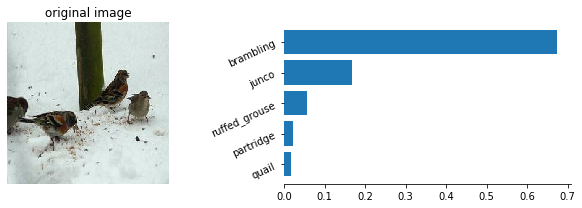

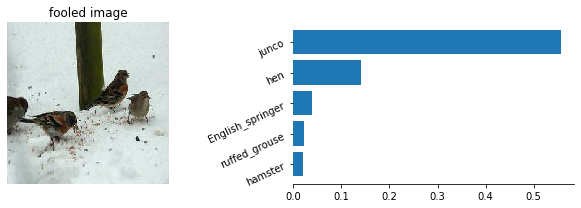

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['indigo_bunting', 'jay', 'macaw', 'house_finch', 'prison']


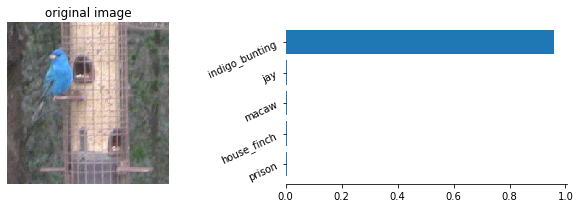

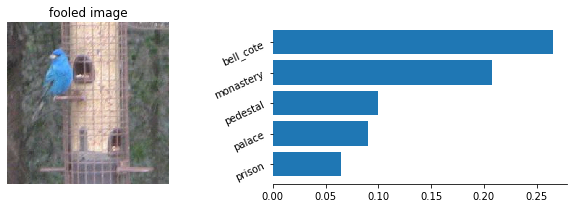

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['loggerhead', 'tailed_frog', 'mud_turtle', 'leatherback_turtle', 'terrapin']


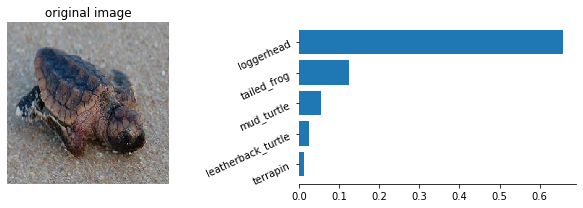

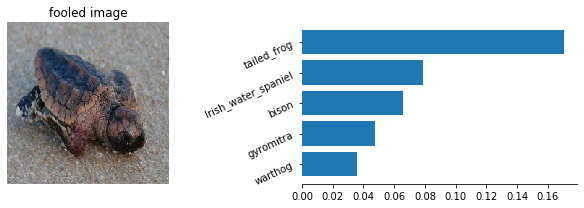

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['frilled_lizard', 'agama', 'marmot', 'fox_squirrel', 'great_grey_owl']


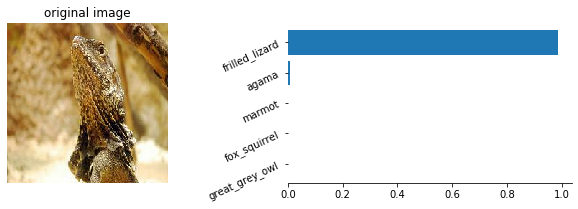

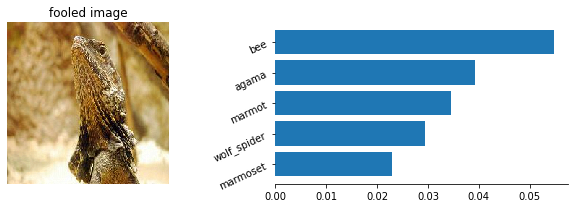

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['black_and_gold_garden_spider', 'garden_spider', 'barn_spider', 'spider_web', 'goldfinch']


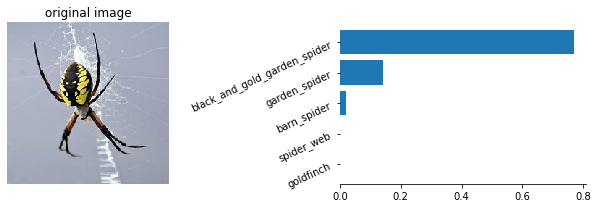

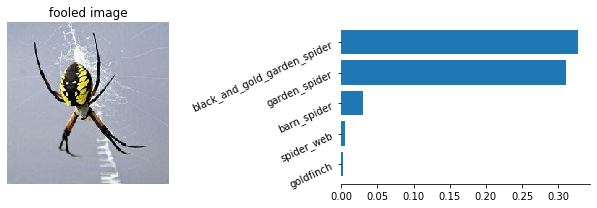

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['African_grey', 'terrapin', 'leatherback_turtle', 'plastic_bag', 'drake']


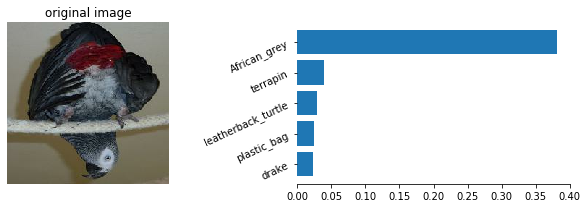

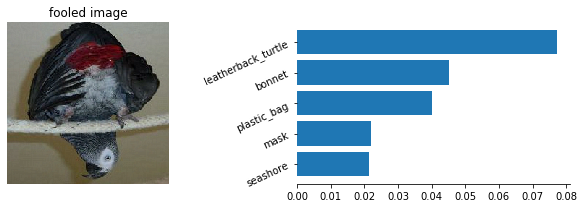

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['hornbill', 'vulture', 'black_grouse', 'toucan', 'coucal']


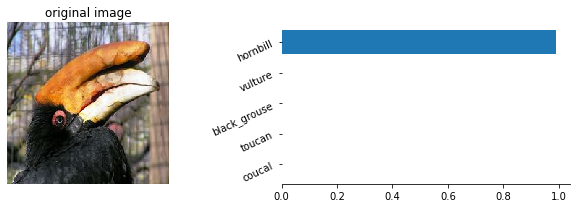

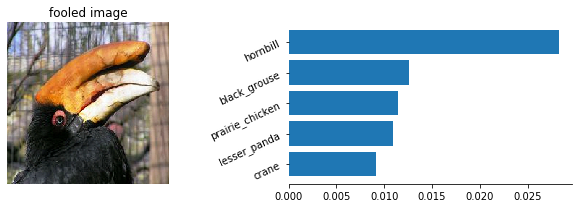

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['wallaby', 'coyote', 'grey_fox', 'hare', 'wood_rabbit']


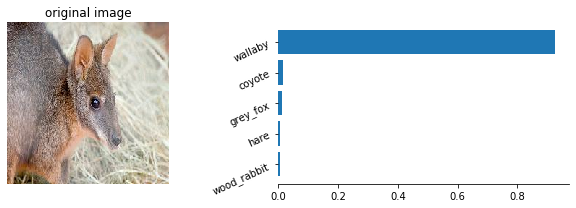

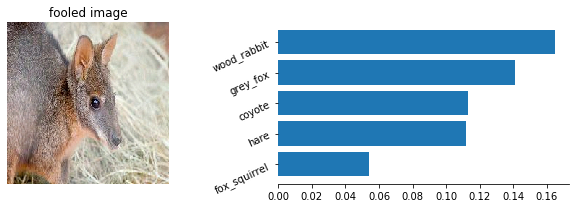

--------------------------------------------------
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

['chiton', 'isopod', 'rock_crab', 'sea_cucumber', 'snail']


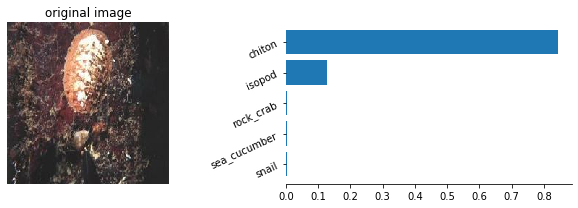

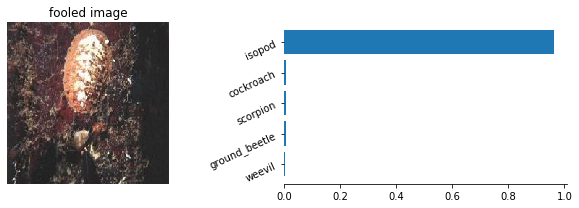

--------------------------------------------------
The algorithm was successful in 75 attempts so far


In [26]:
for f in list_of_files[0:10]:
    
    image_raw = tf.io.read_file(f)
    image = tf.image.decode_png(image_raw)
    input_image = preprocess(image)
    reversed_image = reverse_preprocess(input_image)

    input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

    pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)

    # node to load pretrained weights
    pretrained_ops = pretrained_model.pretrained()

    # decode predicted probabilities to ImageNet labels
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)

    sess.run(pretrained_ops)
    preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
    image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})
    
    top5 = get_imagenet_label(image_probs[0])
    tick_names = [x[1] for x in top5]
    print(tick_names)
    probs = [x[2] for x in top5]
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(reversed_img[0])
    plt.title('original image')
    ax = plt.gca()
    ax.axis('off')

    plt.subplot(122)
    tick_names = [x[1] for x in reversed(top5)]
    probs = [x[2] for x in reversed(top5)]
    plt.barh(tick_names, probs)
    plt.yticks(rotation=25)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    plt.show()
    
    perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))
    
    #print(perturbations.shape)
    #p_cliped = tf.clip_by_value(perturbations, 0, 1)

    #p_cliped_val = sess.run(p_cliped, {input_image_placeholder: preprocessed_img})
    #plt.figure()
    #plt.imshow(p_cliped_val[0])
    #plt.gca().axis('off')
    #plt.show()

    
    # Calculate the top 1 for the new image
    img_probs_attacked = sess.run(pretrained_model, {input_image_placeholder: raw_img_atcked})
    top_1_attacked = list(get_imagenet_label(img_probs_attacked))[0]


    ## START YOU CODE HERE
    adv_x = input_image + 0.01*perturbations
    ## End
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x,"fooled image")
    
  
    #rev_image_atcked = reverse_preprocess(adv_x)
    #_, raw_img_atcked = sess.run([image, rev_image_atcked], {input_image_placeholder: preprocessed_img})
    
    print("-"*50)


    #fooled = try_fool(f, 0.01)
    #if fooled:
    count += 1
        
print(f'The algorithm was successful in {count} attempts so far')

In [27]:
print(f'The algorithm was successful in {count} attempts out of 100, so it has a {count/100} success rate')

The algorithm was successful in 75 attempts out of 100, so it has a 0.75 success rate


# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways attack and fool an AI system. Here are the main points you should remember:

- It is very easy to fool a computer vision system if you know the model and its parameters.
- When designing an AI system, you need to think of adverse attacks againsts your system.

Congratulations on finishing this notebook! 

